### Installing and importing the required modules

In [1]:
# Important: Unsloth must be imported before trl to avoid version conflicts
import unsloth

import os
import sys
import torch
import dotenv
import warnings
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from huggingface_hub import login
from trl import SFTTrainer, SFTConfig
from transformers import TextStreamer
from unsloth import FastLanguageModel
from datasets import Dataset, load_dataset
from unsloth.chat_templates import train_on_responses_only, get_chat_template

# Add the parent directory to the system path
sys.path.append(str(Path().resolve().parent.parent.parent))

# Import local dependencies
from src.utils import get_device, set_seed

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
# Load environment variables
dotenv.load_dotenv(dotenv_path=".env", override=True)

False

### Setting up the environment

In [3]:
# Extract the hugging face token from the user data
HF_TOKEN = os.getenv('HF_TOKEN')

# Check if the HF token has been provided
if not HF_TOKEN:
  # Raise an exception if the HF token was not provided
  raise Exception("Token is not set. Please save the token first.")

# Authenticate with hugging face
login(HF_TOKEN)

# Login successful
print("Successfully logged in to Hugging Face!")

Successfully logged in to Hugging Face!


In [4]:
# Disable warnings
warnings.filterwarnings("ignore")

### Constants, hyperparameters and model configurations

In [5]:
# Set the plot style
plt.style.use('ggplot')

In [6]:
seed = 42 # Seed for reproducibility
test_size = 0.2 # Train-test split percentage
max_seq_length = 512 # Maximum sequence length
model_id = "unsloth/Qwen3-1.7B-unsloth-bnb-4bit" # The model ID
dataset_name = "Amod/mental_health_counseling_conversations" # The path to the dataset
model_path = Path().resolve().parent.parent.parent / "saved_models" / "mental_health_chatbot" # Path to save the trained model to

In [7]:
# Set the seed for reproducibility
set_seed(seed)

In [8]:
# Get the device available on the system
device = get_device()
use_cuda = torch.cuda.is_available() and "cuda" in str(device).lower()

# Print the detected device
print(f"Detected device: {device}")

Detected device: cuda


### Data loading

In [9]:
# Load the dataset into a pandas DataFrame
data = load_dataset(dataset_name, split="train")

# Check if the loaded data is a Dataset
if isinstance(data, Dataset):
	dataset = data
else:
    # Raise an exception if the dataset could not be loaded
	raise Exception(f"Dataset could not be loaded. Invalid type: {type(data)}")

# Remove rows with missing values in the "Context" or "Response" columns
dataset = dataset.filter(lambda x: x["Context"] is not None and x["Response"] is not None)
dataset = dataset.map(lambda x: {"Context_length": len(x["Context"]), "Response_length": len(x["Response"])})

In [10]:
# Display the first 5 rows of the dataset
data_df = dataset.to_pandas()

# Check that the dataset is a pandas DataFrame
if isinstance(data_df, pd.DataFrame):
	dataset_df = data_df
else:
	# Raise an exception if the dataset could not be converted to a DataFrame
	raise Exception(f"Dataset could not be converted to DataFrame. Invalid type: {type(data_df)}")

assert isinstance(dataset_df, pd.DataFrame)
display(dataset_df.head())

,Context,Response,Context_length,Response_length
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",328,961
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",328,2082
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,328,299
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,328,844
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,328,337


### Exploratory data analysis

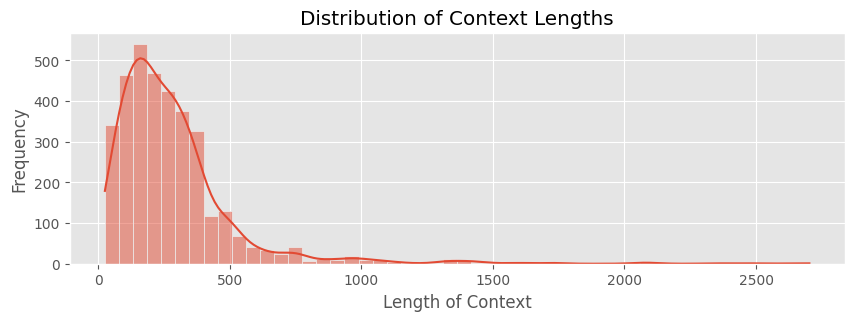

In [11]:
# Length of the words in each context
dataset_df['Context_length'] = dataset_df['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data=dataset_df, x='Context_length', bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

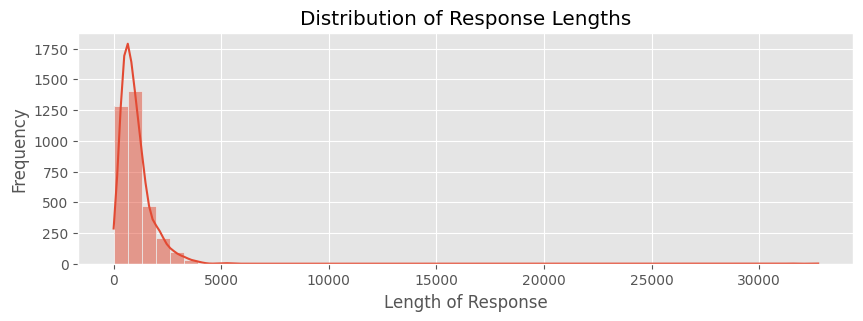

In [12]:
# Length of the words in each response
dataset_df['Response_length'] = dataset_df['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data=dataset_df, x='Response_length', bins=50, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

### Building the model

In [13]:
# Determine whether to load the model in 4-bit or float32
load_in_4bit = bool(torch.cuda.is_available())

# Loading the model and the tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,
    max_seq_length = max_seq_length,
    load_in_4bit = load_in_4bit
)

==((====))==  Unsloth 2025.11.1: Fast Qwen3 patching. Transformers: 4.57.1.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 47.428 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [14]:
# Loading the model and applying LoRA (Low-rank adaptation) to the model
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0.1,
    target_modules = [ 
        "q_proj",
        "k_proj", 
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    use_rslora = True,
    use_gradient_checkpointing = "unsloth",
    random_state = seed,
    loftq_config = None
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.11.1 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [15]:
# Print trainable parameters
model.print_trainable_parameters()

trainable params: 17,432,576 || all params: 1,738,007,552 || trainable%: 1.0030


### Data preparation

In [16]:
# Set the chat template for the tokenizer
tokenizer = get_chat_template(tokenizer, chat_template="qwen3-instruct")

# Function to format the prompts
def formatting_prompt(examples: dict) -> dict:
	# Extract contexts and responses
	contexts = examples["Context"]
	responses = examples["Response"]

	# Initialize list to hold formatted texts
	texts = []

	# Iterate through contexts and responses
	for context, response in zip(contexts, responses):
		# Initialize the prompt using the chat template
		messages = [
			{"role": "user", "content": context},
			{"role": "assistant", "content": response},
		]
  
        # Apply the chat template to format the messages
		text = tokenizer.apply_chat_template(
			messages,
			add_generation_prompt = False,
			tokenize = False
		)
   
		# Append the formatted text to the list
		texts.append(text)
		
	# Return the formatted texts
	return {"text": texts}

In [17]:
# Formatting the training data
dataset = dataset.map(formatting_prompt, batched=True)

# Train-test split
train_dataset, test_dataset = dataset.train_test_split(test_size=test_size, seed=seed).values()

### Trainig the model

In [ ]:
# Instantiate the trainer to train the model
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    eval_dataset = test_dataset,
	processing_class = tokenizer,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        eval_strategy = "steps",
        warmup_steps = 5,
        num_train_epochs = 5,
        learning_rate = 3e-4,
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = seed,
        report_to = "none",
    )
)

# Modify the trainer to train on responses only
train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part = "<|im_start|>assistant\n",
)

Unsloth: Tokenizing ["text"] (num_proc=64):   0%|          | 0/3512 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=64):   0%|          | 0/703 [00:00<?, ? examples/s]

Map (num_proc=64):   0%|          | 0/3512 [00:00<?, ? examples/s]

Map (num_proc=64):   0%|          | 0/703 [00:00<?, ? examples/s]

In [ ]:
# Training the model
trainer_stats = trainer.train()

### Save the model

In [23]:
# Merge LoRA weights into the base model
model.save_pretrained_merged(model_path, tokenizer=tokenizer)

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /workspace/.hf_home/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:42<00:00, 42.48s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


Unsloth: Merge process complete. Saved to `/workspace/Fine-Tuning-LLMs/saved_models/mental_health_chatbot`


### Load the fine-tuned model

In [24]:
# Clear GPU cache
if torch.cuda.is_available():
	torch.cuda.empty_cache()

In [25]:
# Loading the fine-tuned model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = str(model_path),
    max_seq_length = max_seq_length,
    load_in_4bit = load_in_4bit
)


==((====))==  Unsloth 2025.11.1: Fast Qwen3 patching. Transformers: 4.57.1.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 47.428 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [26]:
# Set the model to evaluation mode
model.eval();

### Inference

In [27]:
# Example context for analysis
context = (
	"I've been feeling really overwhelmed lately with everything going on in my life. "
	"Work has been stressful, and I barely have time to relax. "
	"Sometimes I just feel like I'm drowning in responsibilities and can't catch a break. "
	"I try to stay positive, but it's hard when it feels like there's no end in sight."
)

# Initialize the prompt using the chat template
messages = [
	{"role": "user", "content": context}
]

# Apply the chat template to format the messages
text = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt = True,
	tokenize = False
)

# Tokenize the formatted prompt
inputs = tokenizer(
    text,
    truncation = True,
    padding = "longest",
    return_tensors = "pt"
).to(device)

In [28]:
# Disable gradient calculation
with torch.no_grad():
    # Generate the responses
	outputs = model.generate(
		**inputs,
		max_new_tokens = 256,
		temperature = 0.7, 
  		top_p = 0.8, 
    	top_k = 20,
		streamer = TextStreamer(tokenizer, skip_prompt = True)
	)

Feeling overwhelmed is a common experience for many people.  Feeling overwhelmed can be defined as a sense of being unable to handle the demands of life.  Feeling overwhelmed can be caused by a variety of factors including but not limited to:  increased responsibilities, lack of support systems, and/or increased stressors.  Feeling overwhelmed can be alleviated by practicing self-care, learning to prioritize, and/or seeking support.  Self-care is defined as the practice of engaging in activities that promote physical, emotional, and spiritual well-being.  Prioritizing is defined as the practice of determining what is most important to you and allocating time and energy accordingly.  Seeking support is defined as the practice of seeking out people who can help you deal with life's challenges.  In regards to seeking support, there are many ways to seek support including but not limited to:  seeking support from friends and family, joining a support group, and/or engaging in therapy.  In 

In [29]:
# Decode the generated response
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the generated response
print("Generated Response:")
print(response)

Generated Response:
user
I've been feeling really overwhelmed lately with everything going on in my life. Work has been stressful, and I barely have time to relax. Sometimes I just feel like I'm drowning in responsibilities and can't catch a break. I try to stay positive, but it's hard when it feels like there's no end in sight.
assistant
Feeling overwhelmed is a common experience for many people.  Feeling overwhelmed can be defined as a sense of being unable to handle the demands of life.  Feeling overwhelmed can be caused by a variety of factors including but not limited to:  increased responsibilities, lack of support systems, and/or increased stressors.  Feeling overwhelmed can be alleviated by practicing self-care, learning to prioritize, and/or seeking support.  Self-care is defined as the practice of engaging in activities that promote physical, emotional, and spiritual well-being.  Prioritizing is defined as the practice of determining what is most important to you and allocati